<a href="https://www.kaggle.com/code/riturajpradhan/temporal-intro?scriptVersionId=190537309" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import json

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from transformers import AutoImageProcessor, ResNetModel
from transformers.image_processing_base import BatchFeature

2024-07-30 09:07:01.443649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 09:07:01.443827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 09:07:01.593793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
image_paths = []
labels = []
label_path = '/kaggle/input/abaw-7-dataset/validation_set_annotations.txt'
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'

with open(label_path, 'r') as f:
    f.readline()
    data = f.readlines()

for d in data:
    line = d.split(',')
    image_name = line[0]
    image_label = line[3]
    if int(image_label) == -1:
        continue
    image_path = os.path.join(data_path, image_name)
    image_paths.append(image_path)
    labels.append(image_label)

In [15]:
os.remove('/kaggle/working/val/image_features_val_31.pt')

In [16]:
# run cell to extract image features and store them

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetModel.from_pretrained("microsoft/resnet-50").to('cuda')

# batch_images = [Image.open(image_path) for image_path in image_paths[0:50]]
# inputs = image_processor(batch_images, return_tensors="pt")
# with torch.no_grad():
#     output = model(**inputs)
# last_hidden_states = output.last_hidden_state.squeeze()
# pooled_tensor = F.avg_pool2d(last_hidden_states, kernel_size=(7, 7)).squeeze(0)
    
# pooled_tensor.shape    
    
# Batch size for processing images
batch_size = 500

batch_count = 0

# Initialize lists to store extracted features
all_features = []

# Process images in batches
for batch_start in tqdm(range(0, len(image_paths), batch_size), desc='Extracting Features'):
    batch_end = min(batch_start + batch_size, len(image_paths))
    batch_images = [Image.open(image_path) for image_path in image_paths[batch_start:batch_end]]
    
    # Tokenize and extract features
    inputs = image_processor(batch_images, return_tensors="pt").to('cuda')
    with torch.no_grad():
        output = model(**inputs)
    last_hidden_states = output.last_hidden_state.squeeze()
    pooled_tensor = F.avg_pool2d(last_hidden_states, kernel_size=(7, 7)).squeeze()
    # Append features to the list
    all_features.extend(pooled_tensor)

# Save features to a file (e.g., as a PyTorch tensor)
    # Save features every 1000 images
#     if batch_count%50 == 0:
#         output_file = f"./validation_features/image_features_val_{batch_count}.pt"
#         torch.save(torch.stack(all_features).cpu(), output_file)
#         print(f"Features saved to {output_file}")
        
#         # Clear memory by resetting the list
#         all_features = []
    batch_count += 1
    with open('counter.json', 'w') as f:
        json.dump({'batch_count' : batch_count}, f)

# Save any remaining features
if all_features:
    output_file = f"./validation_features/image_features_val_{batch_count}.pt"
    torch.save(torch.stack(all_features).cpu(), output_file)
    print(f"Remaining features saved to {output_file}")


Extracting Features:   0%|          | 0/31 [00:00<?, ?it/s]

Remaining features saved to ./validation_features/image_features_val_31.pt


In [3]:
# loading image features to RAM
# just load it from ABAW_training_features.pt
t = []
for i in [0,50,100,150,182]:
    t.append(torch.load(f'/kaggle/working/val/image_features_val_{str(i)}.pt'))
    
image_features = torch.row_stack(t)
image_features.requires_grad=True
image_features.shape

torch.Size([90645, 2048])

In [17]:
image_features = torch.load('/kaggle/working/validation_features/image_features_val_31.pt')

print(image_features.shape)

labels = [int(x) for x in labels]
label_tensor = torch.tensor(labels)
label_tensor.shape

torch.Size([15440, 2048])


torch.Size([15440])

In [18]:
class ImageTransformer(nn.Module):
    def __init__(self, feature_dim, num_classes, num_heads=8, num_layers=6, dropout=0.1, sequence_length = 64):
        super(ImageTransformer, self).__init__()
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, sequence_length, feature_dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.fc1 = nn.Linear(feature_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)  # Adjust output layer to match the number of classes
        self.softmax = nn.Softmax(0)  # Add softmax layer
    
    def forward(self, pixel_values):
        seq_len, feature_dim = pixel_values.shape
        positional_encoding = self.positional_encoding.squeeze()
        
        # Add positional encoding
        pixel_values = pixel_values + positional_encoding
        
        # Transformer encoder
        x = self.transformer_encoder(pixel_values)
#         print(x.shape)
        
        # Pooling: take the mean of the sequence
        x = x.mean(dim=0)
#         print(x.shape)
        
        # Classification
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
#         print(x.shape) 
#         print(x)
        # Apply softmax to get probability scores
        x = self.softmax(x)
#         print(x.shape)
        return x


In [7]:
# Example dataset class
class ABAWFeatureDataset(Dataset):
    def __init__(self, features, labels, sequence_length):
        self.features = features
        self.labels = labels
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

# Custom collate function
def custom_collate_fn(batch):
    features = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    features = torch.stack(features, dim=0)
    labels = torch.stack(labels, dim=0)
    
    return features, labels

# Create dataset and dataloader
dataset = ABAWFeatureDataset(image_features, label_tensor, sequence_length = 64)
data_loader_train = DataLoader(dataset, batch_size=64, collate_fn=custom_collate_fn)

# Iterate through the DataLoader
for a, b in data_loader_train:
    print(a.shape)  # Should print torch.Size([2, 90645, 2048]) for batch_size=2
    print(b.shape)  # Should print torch.Size([2, 90645]) for batch_size=2
    break


torch.Size([64, 2048])
torch.Size([64])


In [8]:
# Training with Batched features

# Hyperparameters
feature_dim = 2048
num_classes = 8
batch_size = 128
num_epochs = 10
learning_rate = 1e-4
sequence_length = 64

# Model, loss function, optimizer
model = ImageTransformer(feature_dim=feature_dim, num_classes=num_classes, sequence_length = sequence_length).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# try SGD Optimizer 
 
loss_list = []

image_features = image_features.cuda()
label_tensor = label_tensor.cuda()

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    seq_start = 0
    seq_end = sequence_length
    progress_bar = tqdm(total = len(labels))
    while seq_end < label_tensor.shape[0]:
        optimizer.zero_grad()
        out = []
        targets = []
        for i in range(batch_size):
            if seq_end >= label_tensor.shape[0]:
                break
            inputs = image_features[seq_start:seq_start + sequence_length, : ]
            target = label_tensor[seq_end]
#             print('hello',inputs.shape)
#             print(targets.shape)
            # Forward pass
            outputs = model(inputs)

            # Reshape outputs and targets to be compatible with the loss function
            outputs = outputs.view(-1, num_classes)
            out.append(outputs)
            target = target.view(-1)
            targets.append(target)
            seq_start += 1
            seq_end += 1
            if seq_end % 100 == 0:
                progress_bar.update(100)
                    # Calculate loss
        pred = torch.row_stack(out)
        truth = torch.tensor(targets).cuda()
        loss = criterion(pred, truth)
        # Backward pass and optimize
#             print(loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        loss_list.append(loss.item())
        # Update progress bar with current loss
#         data_loader.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    torch.save(model.state_dict(), f'transformer_on_resnet_50_e{epoch}.pth')
    progress_bar.close()

print("Training complete!")


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/90645 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.0720


  0%|          | 0/90645 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
len(labels) - sequence_length

15376

In [27]:
# Validation

model = ImageTransformer(feature_dim=feature_dim, num_classes=num_classes, sequence_length = sequence_length).to('cuda')
model.load_state_dict(torch.load('/kaggle/working/transformer_on_resnet_50_e0.pth'))
model.eval()
seq_start = 0
seq_end = sequence_length
progress_bar = tqdm(total = len(labels))
preds = []
with torch.no_grad():
    while seq_end < label_tensor.shape[0]:

        inputs = image_features[seq_start:seq_start + sequence_length, : ].cuda()
        target = label_tensor[seq_end]
    #             print('hello',inputs.shape)
    #             print(targets.shape)
        # Forward pass
        outputs = model(inputs)
        preds.append(torch.argmax(outputs).item())
        seq_start += 1
        seq_end += 1
        progress_bar.update(1)

print(len(preds))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/15440 [00:00<?, ?it/s]

15376


In [36]:
from scipy.ndimage import gaussian_filter1d
import numpy as np

preds = torch.tensor(preds)
preds.to('cpu')

sigma = 1.0  # Standard deviation of the Gaussian kernel
filtered_array = gaussian_filter1d(preds, sigma=sigma)

# Discretize the filtered values
discretized_array = np.round(filtered_array).astype(int)  # Round and convert to integers

# Convert the result back to a PyTorch tensor
filtered_tensor = torch.tensor(discretized_array, dtype=torch.int)


filtered_tensor.shape

/tmp/ipykernel_324/1067832041.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = torch.tensor(preds)


torch.Size([15376])

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Example ground truth and predictions
y_true = label_tensor[sequence_length:]  # True labels
y_pred = preds  # Predicted labels

# Calculate precision, recall, and F1 score for different averaging methods
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f'Precision (macro): {precision_macro:.2f}')
print(f'Recall (macro): {recall_macro:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')

print(f'Precision (micro): {precision_micro:.2f}')
print(f'Recall (micro): {recall_micro:.2f}')
print(f'F1 Score (micro): {f1_micro:.2f}')

print(f'Precision (weighted): {precision_weighted:.2f}')
print(f'Recall (weighted): {recall_weighted:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

accuracy = accuracy_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.2f}')


Precision (macro): 0.00
Recall (macro): 0.12
F1 Score (macro): 0.01
Precision (micro): 0.04
Recall (micro): 0.04
F1 Score (micro): 0.04
Precision (weighted): 0.00
Recall (weighted): 0.04
F1 Score (weighted): 0.00
Accuracy: 0.04


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# Hyperparameters
feature_dim = 2048
num_classes = 8
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
sequence_length = 50

# Model, loss function, optimizer
model = ImageTransformer(feature_dim=feature_dim, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# try SGD Optimizer 

loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    i = sequence_length - 1
        

    data_loader = tqdm(range(label_tensor.shape[0] - sequence_length), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    loss_list = []
    for i in data_loader:
        optimizer.zero_grad()
        inputs = image_features[i:i+sequence_length, :]
        target = label_tensor[i+sequence_length - 1].unsqueeze(0)
        outputs = model(inputs)
        pred = torch.tensor(float(outputs.argmax().item())).unsqueeze(0)
        pred.requires_grad = True
        target.requires_grad = True
        other_tensor = torch.ones_like(pred)  # A tensor of ones, same shape as dreamy_tensor
        pred = pred * other_tensor
        target = target * other_tensor

        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Update progress bar with current loss
        data_loader.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / len(dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

print("Training complete!")


KeyboardInterrupt: 

tensor([5.], grad_fn=<MulBackward0>)

In [37]:
torch.tensor(float(outputs.argmax().item()))

tensor(5.)

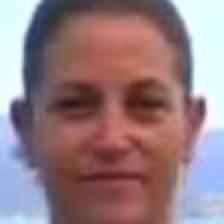

In [64]:
img = Image.open('/kaggle/input/abaw-7-dataset/cropped_aligned/1-30-1280x720/00001.jpg').convert('RGB')
transform = transforms.Compose([
            transforms.Resize([224, 224])
        ])

transform(img)